In [1]:
!gdown --id 1OUsK1LxfYarB3Mqgh4UVhkNM7U2TQ9s9

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1OUsK1LxfYarB3Mqgh4UVhkNM7U2TQ9s9
From (redirected): https://drive.google.com/uc?id=1OUsK1LxfYarB3Mqgh4UVhkNM7U2TQ9s9&confirm=t&uuid=95ad968d-c330-4fe8-afd6-b0449ab93d6f
To: /content/nature_12K.zip
100% 3.82G/3.82G [00:53<00:00, 71.2MB/s]


In [ ]:
!unzip "/content/nature_12K.zip"

In [3]:
!nvidia-smi

Fri Apr 18 05:40:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
!pip install -q  pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 60.9 MB/s eta 0:00:00


In [5]:
import os
import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from pytorch_lightning.loggers import WandbLogger
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.model_selection import StratifiedShuffleSplit

In [6]:
project_name='DA6401_Assignment2'
# wandb.login()
wandb.init(project=project_name)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: venkatesh19v (venkatesh19v-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [7]:
# Define a flexible activation function getter
def get_activation(name):
    name = name.lower()
    return {
        "relu": nn.ReLU(),
        "gelu": nn.GELU(),
        "silu": nn.SiLU(),
        "mish": nn.Mish()
    }[name]

In [8]:
class CNN(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.save_hyperparameters(dict(config))
        m = config["num_filters"]
        k = config["kernel_size"]
        act = get_activation(config["activation"])
        use_bn = config["batch_norm"]
        do_p = config["dropout_prob"]

        # Define conv block
        def conv_block(in_ch, out_ch):
            layers = [nn.Conv2d(in_ch, out_ch, k, padding=k // 2)]
            if use_bn:
                layers.append(nn.BatchNorm2d(out_ch))
            layers.append(act)
            layers.append(nn.MaxPool2d(2))
            if do_p > 0:
                layers.append(nn.Dropout2d(do_p))
            return nn.Sequential(*layers)

        # Filter organization
        if config["filter_scheme"] == "same":
            fs = [m] * 5
        elif config["filter_scheme"] == "double":
            fs = [m * (2 ** i) for i in range(5)]
        elif config["filter_scheme"] == "half":
            fs = [max(1, m // (2 ** i)) for i in range(5)]
        else:
            raise ValueError("Invalid filter scheme")

        # CNN architecture
        self.blocks = nn.Sequential(
            conv_block(3, fs[0]),
            conv_block(fs[0], fs[1]),
            conv_block(fs[1], fs[2]),
            conv_block(fs[2], fs[3]),
            conv_block(fs[3], fs[4]),
        )

        # Compute flattened feature size
        dummy = torch.zeros(1, 3, config["img_size"], config["img_size"])
        flat = self.blocks(dummy).view(1, -1).size(1)

        self.fc1 = nn.Linear(flat, config["dense_neurons"])
        self.act_fc = act
        self.drop_fc = nn.Dropout(do_p)
        self.out = nn.Linear(config["dense_neurons"], config["num_classes"])
        self.lr = config["lr"]

    def forward(self, x):
        x = self.blocks(x)
        x = x.view(x.size(0), -1)
        x = self.act_fc(self.fc1(x))
        x = self.drop_fc(x)
        return self.out(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(1) == y).float().mean()
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(1) == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [9]:
def train_cnn(config):
    wandb.init(project="DA6401_Assignment2", config=config)
    config = dict(wandb.config)

    # Prepare data loaders
    def prepare_data_loaders(batch_size, img_size):
        tfm = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
        ])
        full = datasets.ImageFolder("inaturalist_12K/train", transform=tfm)
        labels = [y for _, y in full.samples]
        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
        train_idx, val_idx = next(sss.split(full.samples, labels))
        train_ds = Subset(full, train_idx)
        val_ds = Subset(full, val_idx)
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)
        return train_loader, val_loader

    train_loader, val_loader = prepare_data_loaders(config["batch_size"], config["img_size"])

    # Model + logger + trainer
    model = CNN(config)
    wandb_logger = WandbLogger(project="DA6401_Assignment2", log_model="all")
    trainer = pl.Trainer(
        max_epochs=10,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1,
        logger=wandb_logger,
        log_every_n_steps=10,
    )

    trainer.fit(model, train_loader, val_loader)
    wandb.finish()

In [10]:
#Hyperparameters
config = {
    "num_filters": 32,
    "kernel_size": 3,
    "activation": "relu",
    "filter_scheme": "same",
    "batch_norm": True,
    "dropout_prob": 0.2,
    "dense_neurons": 128,
    "lr": 1e-3,
    "batch_size": 64,
    "img_size": 224,
    "num_classes": 10
}

train_cnn(config)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


epoch,▁▁▁▂▂▃▃▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇██
train_acc_epoch,▁▄▆▆▇▇████
train_acc_step,▂▁▄▅▄▆▆▅▃▄▅▇▃▅▅▅▄▄▄▆▅▆▄▅▆▆▅▆▄██▇▆▅█▇▆▄▅▆
train_loss_epoch,█▅▄▃▃▂▂▁▁▁
train_loss_step,█▆▆▆▆▅▆▃▅▂▃▅▃▁▅▂▅▅▃▂▂▂▁▃▄▃▂▂▄▃▂▁▃▅▂▂▄▂▃▃
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇███
val_acc,▁▃▅▅▆▇▆▇██
val_loss,█▆▄▃▃▂▃▂▁▁
epoch,9
train_acc_epoch,0.28766
train_acc_step,0.15873


In [14]:
import glob

test_transform = transforms.Compose([
    transforms.Resize((config["img_size"], config["img_size"])),
    transforms.ToTensor()
])
test_dataset = datasets.ImageFolder("inaturalist_12K/val", transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=4)
class_names = test_dataset.classes

ckpt_path = "/content/DA6401_Assignment2/s5ngriy8/checkpoints/epoch=9-step=1250.ckpt"  # Replace with actual path

model = CNN.load_from_checkpoint(ckpt_path, config=config)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

all_preds, all_labels = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        preds = logits.argmax(1)
        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)
test_acc = (all_preds == all_labels).float().mean().item()

print(f"\nTest Accuracy: {test_acc:.4f}")



Test Accuracy: 0.3400


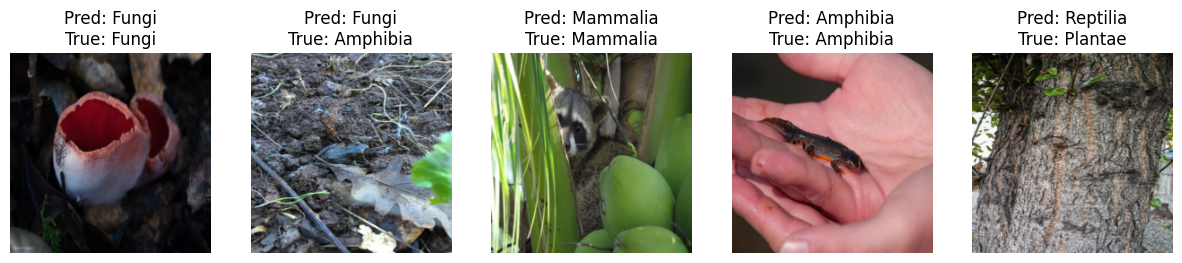

In [19]:
import random
wandb.init(project=project_name)
sample_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)
images, labels = next(iter(sample_loader))
images = images.to(device)
labels = labels.to(device)

with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(1)

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i, idx in enumerate(random.sample(range(len(images)), 5)):
    img = images[idx].cpu().permute(1, 2, 0)
    axs[i].imshow(img)
    axs[i].axis("off")
    axs[i].set_title(f"Pred: {class_names[preds[idx]]}\nTrue: {class_names[labels[idx]]}")
plt.show()
wandb.log({"Sample Predictions": wandb.Image(fig)})
